In [0]:
df = spark.table("hive_metastore.default.silver_merged_table")
df.printSchema()


root
 |-- Daily_Usage_Units_x: long (nullable = true)
 |-- Date: string (nullable = true)
 |-- Downtime_Min_x: long (nullable = true)
 |-- Econ_Index_x: long (nullable = true)
 |-- Peak_Usage_Units_x: long (nullable = true)
 |-- Region_x: string (nullable = true)
 |-- Season_x: string (nullable = true)
 |-- Service_x: string (nullable = true)
 |-- Storage_TB_x: long (nullable = true)
 |-- VM_Count_x: long (nullable = true)
 |-- Cloud_Demand_Index: string (nullable = true)
 |-- GDP_Growth: string (nullable = true)
 |-- Inflation: string (nullable = true)
 |-- Competitor_Price_Index: string (nullable = true)
 |-- Region_y: string (nullable = true)
 |-- Service_y: string (nullable = true)
 |-- Daily_Usage_Units_y: string (nullable = true)
 |-- Peak_Usage_Units_y: string (nullable = true)
 |-- VM_Count_y: string (nullable = true)
 |-- Storage_TB_y: string (nullable = true)
 |-- Season_y: string (nullable = true)
 |-- Econ_Index_y: string (nullable = true)
 |-- Downtime_Min_y: string (nulla

In [0]:
from pyspark.sql.functions import to_date, col

df = df.withColumn("Date", to_date(col("Date"), "dd-MM-yyyy"))
df = df.filter(col("Date").isNotNull())


In [0]:
df = df.orderBy("Date")


In [0]:
df = df.withColumn(
    "Daily_Usage_Units_x",
    col("Daily_Usage_Units_x").cast("double")
)

In [0]:
from pyspark.sql.functions import monotonically_increasing_id

df = df.withColumn("t_index", monotonically_increasing_id())


In [0]:
from databricks.connect import DatabricksSession
spark = DatabricksSession.builder.getOrCreate()

In [0]:
#PROPHET
%pip install prophet

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 68.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.7 MB/s eta 0:00:00
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
from prophet import Prophet
from pyspark.sql.functions import col, to_date
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# ----------------------------------------------------
# 1. LOAD & PREPARE DATA
# ----------------------------------------------------
df = (
    spark.table("hive_metastore.default.silver_merged_table")
         .select("Date", "Daily_Usage_Units_x")
         .withColumn("Date", to_date("Date", "dd-MM-yyyy"))
         .dropna()
)

pdf = df.toPandas()
pdf = pdf.sort_values("Date")
pdf = pdf.rename(columns={"Date": "ds", "Daily_Usage_Units_x": "y"})

# ----------------------------------------------------
# 2. TRAIN-TEST SPLIT (last 30 days)
# ----------------------------------------------------
train = pdf[:-30]
test = pdf[-30:]

# ----------------------------------------------------
# 3. TRAIN PROPHET MODEL
# ----------------------------------------------------
model = Prophet()
model.fit(train)

# ----------------------------------------------------
# 4. PREDICT ON TEST DATA (for accuracy)
# ----------------------------------------------------
future_test = test[["ds"]]
forecast_test = model.predict(future_test)

y_true = test["y"].values
y_pred = forecast_test["yhat"].values

# ----------------------------------------------------
# 5. ACCURACY METRICS
# ----------------------------------------------------
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# SMAPE (stable, avoids division by zero)
def smape(y_true, y_pred):
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-10)
    )

smape_value = smape(y_true, y_pred)

metrics_pdf = pd.DataFrame([{
    "model": "Prophet",
    "MAE": float(mae),
    "RMSE": float(rmse),
    "SMAPE": float(smape_value)
}])

metrics_spark = spark.createDataFrame(metrics_pdf)
metrics_spark.write.mode("overwrite").saveAsTable("hive_metastore.default.prophet_accuracy")

print("Prophet Accuracy:")
metrics_spark.show()

# ----------------------------------------------------
# 6. FINAL FORECAST FOR NEXT 90 DAYS
# ----------------------------------------------------
future = model.make_future_dataframe(periods=90)
full_forecast = model.predict(future)

spark_forecast = spark.createDataFrame(
    full_forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]]
)

spark_forecast.write.mode("overwrite").saveAsTable("hive_metastore.default.prophet_forecast")

print("Saved prophet_forecast and prophet_accuracy ✓")


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Prophet Accuracy:
+-------+------------------+-----------------+------------------+
|  model|               MAE|             RMSE|             SMAPE|
+-------+------------------+-----------------+------------------+
|Prophet|62006.933333333334|69374.41932098975|131.44263570121853|
+-------+------------------+-----------------+------------------+

Saved prophet_forecast and prophet_accuracy ✓


In [0]:
%sql
SELECT * FROM hive_metastore.default.prophet_accuracy;

model,MAE,RMSE,SMAPE
Prophet,62006.933333333334,69374.41932098975,131.44263570121853


In [0]:
%sql
SELECT * FROM hive_metastore.default.prophet_forecast ORDER BY ds;

ds,yhat,yhat_lower,yhat_upper
2020-01-01T00:00:00Z,57825.19827688538,-20918.76761698151,140490.73136048493
2020-01-02T00:00:00Z,56945.09672124644,-25322.526858966703,137847.7057403431
2020-01-03T00:00:00Z,56987.01219301292,-26241.772906972117,134442.91900261343
2020-01-04T00:00:00Z,57397.42649445515,-24838.12282989357,137226.55112575734
2020-01-05T00:00:00Z,56704.839534072904,-26267.51475281651,135641.49153298486
2020-01-06T00:00:00Z,56386.341544877745,-22662.79778511391,135015.00393441488
2020-01-07T00:00:00Z,56997.95531136688,-28313.402518456813,141112.69275135928
2020-01-08T00:00:00Z,56303.32522939119,-21896.266910036524,133739.416802514
2020-01-09T00:00:00Z,55560.096932831126,-24373.468518091813,133896.6632238571
2020-01-10T00:00:00Z,55766.64654950882,-22682.071792070514,135839.67766872747


In [0]:
#ARIMA

# ----------------------------------------------------------
# 1. IMPORTS
# ----------------------------------------------------------
from pyspark.sql.functions import to_date
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ----------------------------------------------------------
# 2. LOAD DATA FROM SILVER TABLE
# ----------------------------------------------------------
df = (
    spark.table("hive_metastore.default.silver_merged_table")
    .select("Date", "Daily_Usage_Units_x")
    .withColumn("Date", to_date("Date", "dd-MM-yyyy"))
    .dropna()
)

pdf = df.toPandas().sort_values("Date")

pdf = pdf.rename(columns={"Date": "ds", "Daily_Usage_Units_x": "y"})

# ----------------------------------------------------------
# 3. TRAIN-TEST SPLIT (Last 30 Days For Testing)
# ----------------------------------------------------------
train = pdf[:-30]
test = pdf[-30:]

y_train = train["y"]
y_test = test["y"]

# ----------------------------------------------------------
# 4. TRAIN ARIMA MODEL (AUTO PARAMETERS)
# ----------------------------------------------------------
# You may tune order=(p,d,q)
model = ARIMA(y_train, order=(5,1,2))
model_fit = model.fit()

# ----------------------------------------------------------
# 5. FORECAST ON TEST SET
# ----------------------------------------------------------
forecast_test = model_fit.forecast(steps=len(y_test))

y_pred = forecast_test.values
y_true = y_test.values

# ----------------------------------------------------------
# 6. ACCURACY METRICS
# ----------------------------------------------------------
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

accuracy_pdf = pd.DataFrame([{
    "model": "ARIMA(5,1,2)",
    "MAE": mae,
    "RMSE": rmse,
    "SMAPE": smape
}])

accuracy_spark = spark.createDataFrame(accuracy_pdf)
accuracy_spark.write.mode("overwrite").saveAsTable("arima_accuracy")

print("ARIMA ACCURACY:")
accuracy_spark.show()

# ----------------------------------------------------------
# 7. FINAL FORECAST (Next 90 Days)
# ----------------------------------------------------------
forecast_future = model_fit.forecast(steps=90)

future_dates = pd.date_range(start=pdf["ds"].max(), periods=90+1, closed='right')

forecast_pdf = pd.DataFrame({
    "ds": future_dates,
    "yhat": forecast_future
})

forecast_spark = spark.createDataFrame(forecast_pdf)
forecast_spark.write.mode("overwrite").saveAsTable("arima_forecast")

print("Saved arima_forecast and arima_accuracy")


ARIMA ACCURACY:
+------------+------------------+-----------------+------------------+
|       model|               MAE|             RMSE|             SMAPE|
+------------+------------------+-----------------+------------------+
|ARIMA(5,1,2)|62834.458582828134|72668.76118357357|136.92302674558127|
+------------+------------------+-----------------+------------------+

Saved arima_forecast and arima_accuracy


In [0]:
%pip install xgboost scikit-learn pandas matplotlib pmdarima prophet tqdm

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import pmdarima as pm
from prophet import Prophet
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def smape(y_true, y_pred):
    # Symmetric Mean Absolute Percentage Error
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    # avoid division by zero
    mask = denom == 0
    denom[mask] = 1.0
    diff = np.abs(y_true - y_pred) / denom
    diff[mask] = 0.0
    return 100.0 * np.mean(diff)


In [0]:
# Replace with your table name
table_name = "hive_metastore.default.silver_merged_table"

# Load into a Pandas DataFrame (Databricks' Spark session provides `spark`)
df = spark.table(table_name).toPandas()

# Inspect
print("Rows:", len(df))
display(df.head())

# Parse date column robustly
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
if df['Date'].isna().any():
    # try another format if your dates are like 2020-01-01
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop rows without date
df = df.dropna(subset=['Date']).copy()
df = df.sort_values('Date').reset_index(drop=True)


Rows: 10962


Daily_Usage_Units_x,Date,Downtime_Min_x,Econ_Index_x,Peak_Usage_Units_x,Region_x,Season_x,Service_x,Storage_TB_x,VM_Count_x,Cloud_Demand_Index,GDP_Growth,Inflation,Competitor_Price_Index,Region_y,Service_y,Daily_Usage_Units_y,Peak_Usage_Units_y,VM_Count_y,Storage_TB_y,Season_y,Econ_Index_y,Downtime_Min_y,Usage_Lag_1,Usage_Lag_7,Week_Over_Week_Growth,Seasonality_Factor
79383,01-04-2021,2,100,86402,Central India,Spring,Compute,0,3255,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN
0,01-04-2021,2,102,0,Central India,Spring,Storage,429,0,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN
73981,02-04-2021,0,93,78199,East US,Spring,Compute,0,9119,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN
0,02-04-2021,3,108,0,East US,Spring,Storage,1001,0,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN
103073,02-04-2021,3,97,121305,West Europe,Spring,Compute,0,9869,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN


In [0]:
target_col = 'Daily_Usage_Units_x'

# If there are multiple rows per date (e.g., several regions/services), aggregate by date.
# You can change agg to 'sum' or 'mean' depending on business need.
daily = df.groupby('Date', as_index=False).agg({
    target_col: 'sum',
    'Peak_Usage_Units_x': 'sum',           # exogenous exposures: sums per day
    'Downtime_Min_x': 'mean',
    'Econ_Index_x': 'mean',
    'Storage_TB_x': 'sum',
    'VM_Count_x': 'sum',
    # add other numeric columns present in your table if useful
}).sort_values('Date')

# Ensure continuous daily index (fill missing dates with 0 or interpolation as appropriate)
daily = daily.set_index('Date').asfreq('D')
daily[target_col] = daily[target_col].fillna(0)   # fill missing usage with 0 (or interpolate)
daily['Peak_Usage_Units_x'] = daily['Peak_Usage_Units_x'].fillna(method='ffill').fillna(0)
daily['Downtime_Min_x'] = daily['Downtime_Min_x'].fillna(method='ffill').fillna(0)
daily['Econ_Index_x'] = daily['Econ_Index_x'].fillna(method='ffill').fillna(0)
daily['Storage_TB_x'] = daily['Storage_TB_x'].fillna(0)
daily['VM_Count_x'] = daily['VM_Count_x'].fillna(0)

display(daily.head(10))


Daily_Usage_Units_x,Peak_Usage_Units_x,Downtime_Min_x,Econ_Index_x,Storage_TB_x,VM_Count_x
255790,292072,1.0,95.0,2217,21515
333134,393757,1.6666666666666667,93.16666666666667,2217,29347
300146,333782,0.8333333333333334,90.5,2932,32433
341450,398078,1.1666666666666667,94.16666666666667,2478,14749
348241,401180,1.1666666666666667,96.83333333333333,3148,36118
344604,376970,1.8333333333333333,99.0,1899,16237
389517,467001,0.5,98.0,2834,29730
203471,234997,0.6666666666666666,96.5,1703,13510
303532,347904,0.6666666666666666,90.66666666666667,2161,33523
326217,380727,1.0,90.83333333333333,2112,30476


In [0]:
df_feat = daily.copy()
# target as column
df_feat = df_feat.rename(columns={target_col: 'y'})

# Date-time features
df_feat['dayofweek'] = df_feat.index.dayofweek
df_feat['day'] = df_feat.index.day
df_feat['month'] = df_feat.index.month
df_feat['weekofyear'] = df_feat.index.isocalendar().week.astype(int)

# Lags and rolling windows
for lag in [1, 7, 14, 28]:
    df_feat[f'lag_{lag}'] = df_feat['y'].shift(lag)

for w in [7, 14, 28]:
    df_feat[f'rolling_mean_{w}'] = df_feat['y'].shift(1).rolling(window=w, min_periods=1).mean()

# Seasonal flag if you have Season column in original; fallback to month-based season
# Example: create simple seasonality bucket by month
df_feat['season_bucket'] = df_feat['month'] % 12
# Fill NAs from shifts
df_feat = df_feat.fillna(0)

# Final features list
feature_cols = [c for c in df_feat.columns if c not in ['y']]
print("Feature columns:", feature_cols)


Feature columns: ['Peak_Usage_Units_x', 'Downtime_Min_x', 'Econ_Index_x', 'Storage_TB_x', 'VM_Count_x', 'dayofweek', 'day', 'month', 'weekofyear', 'lag_1', 'lag_7', 'lag_14', 'lag_28', 'rolling_mean_7', 'rolling_mean_14', 'rolling_mean_28', 'season_bucket']


In [0]:
H = 28  # forecast horizon — change as needed
train = df_feat.iloc[:-H].copy()
test = df_feat.iloc[-H:].copy()

X_train = train[feature_cols]
y_train = train['y']
X_test = test[feature_cols]
y_test = test['y']

print("Train range:", train.index.min(), train.index.max())
print("Test range:", test.index.min(), test.index.max())


Train range: 2020-01-01 00:00:00 2024-12-03 00:00:00
Test range: 2024-12-04 00:00:00 2024-12-31 00:00:00


In [0]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "eta": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42
}

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=2000,
    early_stopping_rounds=50,
    evals=watchlist,
    verbose_eval=50
)

# Forecast on test
xgb_preds = bst.predict(dvalid)


[0]	train-rmse:62566.63864	valid-rmse:66934.97430
[50]	train-rmse:12108.12635	valid-rmse:17435.15897
[100]	train-rmse:6397.19611	valid-rmse:12501.89924
[150]	train-rmse:4988.83539	valid-rmse:11996.69490
[200]	train-rmse:4078.56040	valid-rmse:11783.12472
[250]	train-rmse:3339.60890	valid-rmse:11719.08929
[300]	train-rmse:2719.67770	valid-rmse:11741.75033
[310]	train-rmse:2606.13810	valid-rmse:11743.22220


In [0]:
y_train_series = train['y']
y_test_series = test['y']

# auto_arima to choose best seasonal model, weekly seasonality (m=7) since daily data
arima_model = pm.auto_arima(
    y_train_series,
    start_p=0, start_q=0,
    max_p=5, max_q=5,
    seasonal=True, m=7,
    start_P=0, start_Q=0, max_P=2, max_Q=2,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    n_jobs=1
)

arima_forecast = arima_model.predict(n_periods=H)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=45021.766, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=45025.620, Time=1.52 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=45025.540, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=51039.725, Time=0.03 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=45023.760, Time=0.36 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=45023.597, Time=0.22 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=45025.597, Time=1.37 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=45023.703, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=45023.708, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=45025.704, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[7] intercept
Total fit time: 4.164 seconds


In [0]:
prophet_df = train.reset_index()[['Date', 'y']].rename(columns={'Date':'ds'})
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
# add regressors if desired:
# m.add_regressor('Econ_Index_x')
m.fit(prophet_df)

future = m.make_future_dataframe(periods=H, freq='D')
forecast_prophet = m.predict(future)
prophet_forecast = forecast_prophet.set_index('ds')['yhat'][-H:].values


In [0]:
# Make sure arrays are aligned to y_test index
xgb_pred = xgb_preds
arima_pred = arima_forecast
prophet_pred = prophet_forecast

y_true = y_test.values

results = {
    'model': ['XGBoost', 'ARIMA', 'Prophet'],
    'MAE': [
        mean_absolute_error(y_true, xgb_pred),
        mean_absolute_error(y_true, arima_pred),
        mean_absolute_error(y_true, prophet_pred)
    ],
    'RMSE': [
        rmse(y_true, xgb_pred),
        rmse(y_true, arima_pred),
        rmse(y_true, prophet_pred)
    ],
    'SMAPE': [
        smape(y_true, xgb_pred),
        smape(y_true, arima_pred),
        smape(y_true, prophet_pred)
    ]
}
results_df = pd.DataFrame(results)
display(results_df)


model,MAE,RMSE,SMAPE
XGBoost,9068.53627232143,11743.222226523614,2.539107826383422
ARIMA,57345.69340109584,70131.4034114704,15.80210548762086
Prophet,57345.775211006294,70423.29892361627,15.808513780547973


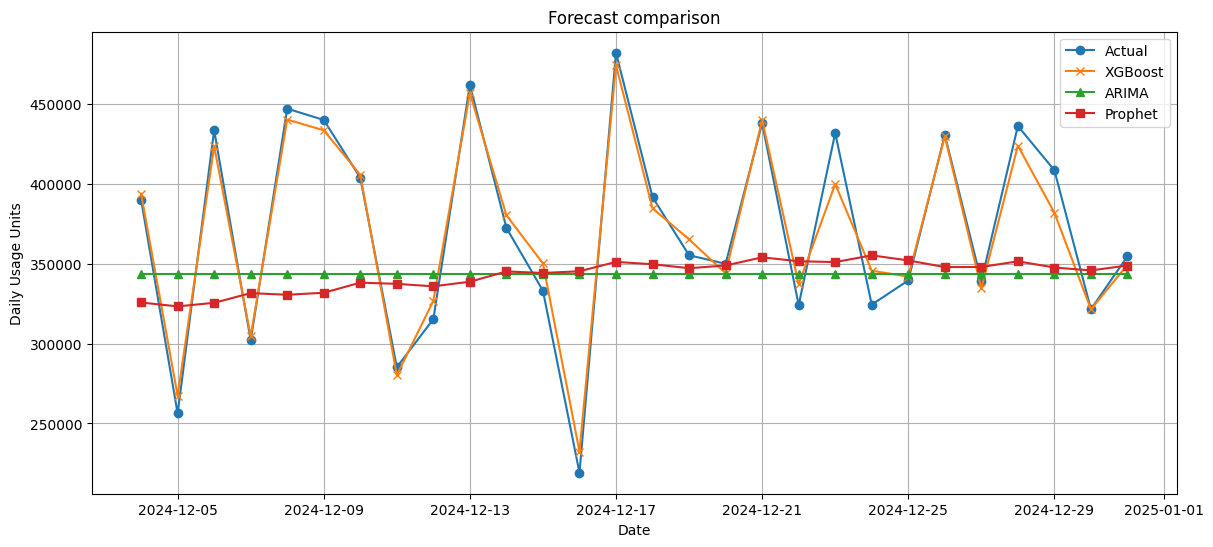

In [0]:
plt.figure(figsize=(14,6))
plt.plot(test.index, y_true, label='Actual', marker='o')
plt.plot(test.index, xgb_pred, label='XGBoost', marker='x')
plt.plot(test.index, arima_pred, label='ARIMA', marker='^')
plt.plot(test.index, prophet_pred, label='Prophet', marker='s')
plt.legend()
plt.title('Forecast comparison')
plt.xlabel('Date')
plt.ylabel('Daily Usage Units')
plt.grid(True)
plt.show()


In [0]:
#XGBoost + RandomForest + ARIMA + Prophet

model,MAE,RMSE,SMAPE
XGBoost,9068.53627232143,11743.222226523614,2.539107826383422
RandomForest,8137.451884278852,10452.599281892997,2.3137917976357922
ARIMA,57345.69340109584,70131.4034114704,15.80210548762086
Prophet,57345.775211006294,70423.29892361627,15.808513780547973


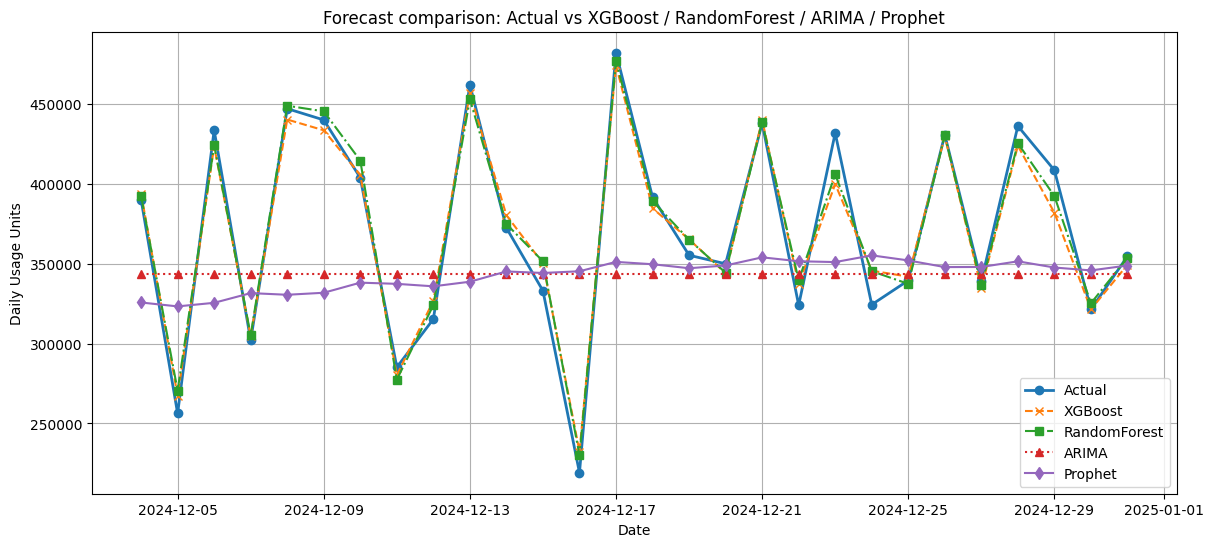

In [0]:
# ---------------------------
# 7-11: XGBoost + RandomForest + ARIMA + Prophet + Metrics + Plot
# (replace previous steps 7-11 with this single cell)
# ---------------------------

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import pmdarima as pm
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt

# helper metrics if not defined
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    mask = denom == 0
    denom[mask] = 1.0
    diff = np.abs(y_true - y_pred) / denom
    diff[mask] = 0.0
    return 100.0 * np.mean(diff)

# Prepare DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)

xgb_params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "eta": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42
}

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
bst = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=2000,
    early_stopping_rounds=50,
    evals=watchlist,
    verbose_eval=False
)

xgb_preds = bst.predict(dvalid)

# -------------------------
# Random Forest (scikit-learn)
# -------------------------
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# -------------------------
# ARIMA (pmdarima) univariate
# -------------------------
y_train_series = train['y']
H = len(y_test)  # horizon
# Use m=7 (weekly seasonality) for daily data; tune if needed
arima_model = pm.auto_arima(
    y_train_series,
    start_p=0, start_q=0,
    max_p=5, max_q=5,
    seasonal=True, m=7,
    start_P=0, start_Q=0, max_P=2, max_Q=2,
    trace=False,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    n_jobs=1
)
arima_forecast = arima_model.predict(n_periods=H)

# -------------------------
# Prophet
# -------------------------
prophet_df = train.reset_index()[['Date', 'y']].rename(columns={'Date':'ds'})
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
m.fit(prophet_df)

future = m.make_future_dataframe(periods=H, freq='D')
forecast_prophet = m.predict(future)
prophet_forecast = forecast_prophet.set_index('ds')['yhat'][-H:].values

# -------------------------
# Collect predictions & compute metrics
# -------------------------
y_true = y_test.values

models = ['XGBoost', 'RandomForest', 'ARIMA', 'Prophet']
preds = [xgb_preds, rf_preds, arima_forecast, prophet_forecast]

metrics = []
for name, pred in zip(models, preds):
    mae_val = mean_absolute_error(y_true, pred)
    rmse_val = rmse(y_true, pred)
    smape_val = smape(y_true, pred)
    metrics.append((name, mae_val, rmse_val, smape_val))

import pandas as pd
results_df = pd.DataFrame(metrics, columns=['model', 'MAE', 'RMSE', 'SMAPE'])
display(results_df)

# -------------------------
# Plot actual vs forecasts
# -------------------------
plt.figure(figsize=(14,6))
plt.plot(test.index, y_true, label='Actual', marker='o', linewidth=2)
plt.plot(test.index, xgb_preds, label='XGBoost', marker='x', linestyle='--')
plt.plot(test.index, rf_preds, label='RandomForest', marker='s', linestyle='-.')
plt.plot(test.index, arima_forecast, label='ARIMA', marker='^', linestyle=':')
plt.plot(test.index, prophet_forecast, label='Prophet', marker='d', linestyle='-')
plt.legend()
plt.title('Forecast comparison: Actual vs XGBoost / RandomForest / ARIMA / Prophet')
plt.xlabel('Date')
plt.ylabel('Daily Usage Units')
plt.grid(True)
plt.show()

# -------------------------
# Optional: Save results table to spark (if you want)
# -------------------------
# results_spark = spark.createDataFrame(results_df)
# results_spark.write.mode('overwrite').format('delta').save('/tmp/forecasting_model_metrics')


model,MAE,RMSE,SMAPE,Accuracy (%)
XGBoost,9068.53627232143,11743.222226523614,2.539107826383422,97.46089217361657
RandomForest,8137.451884278852,10452.599281892997,2.3137917976357922,97.68620820236421
ARIMA,57345.69340109584,70131.4034114704,15.80210548762086,84.19789451237914
Prophet,57345.775211006294,70423.29892361627,15.808513780547973,84.19148621945203


Best Model: RandomForest
Best Model Accuracy: 97.686%


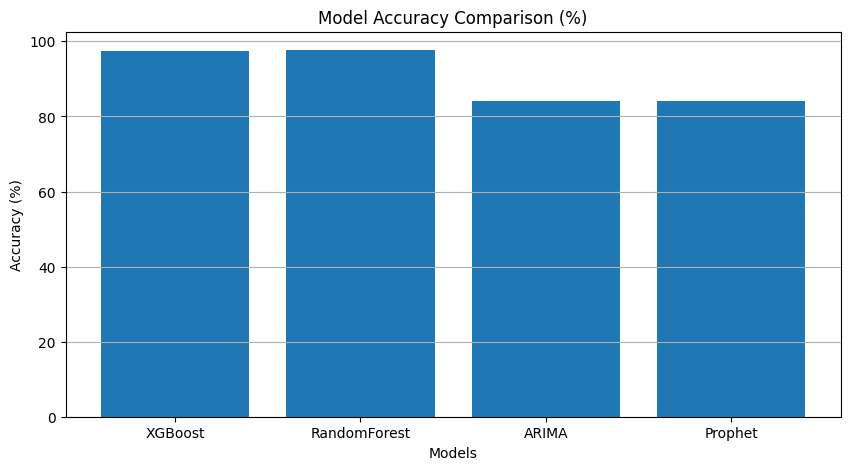

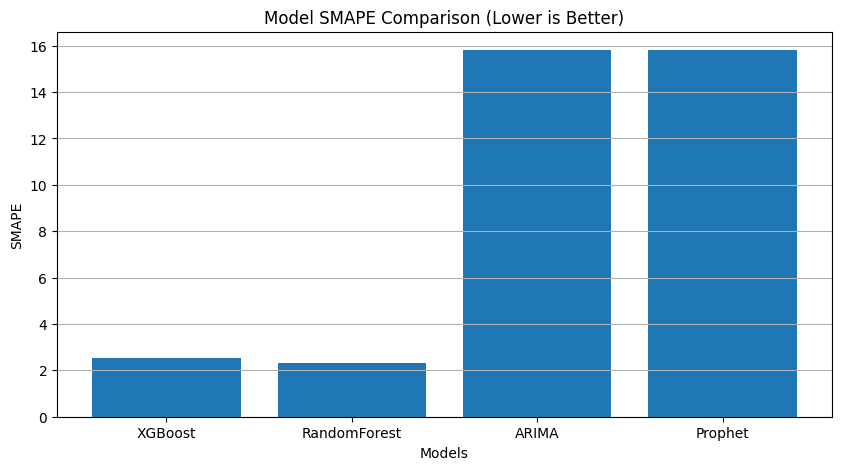

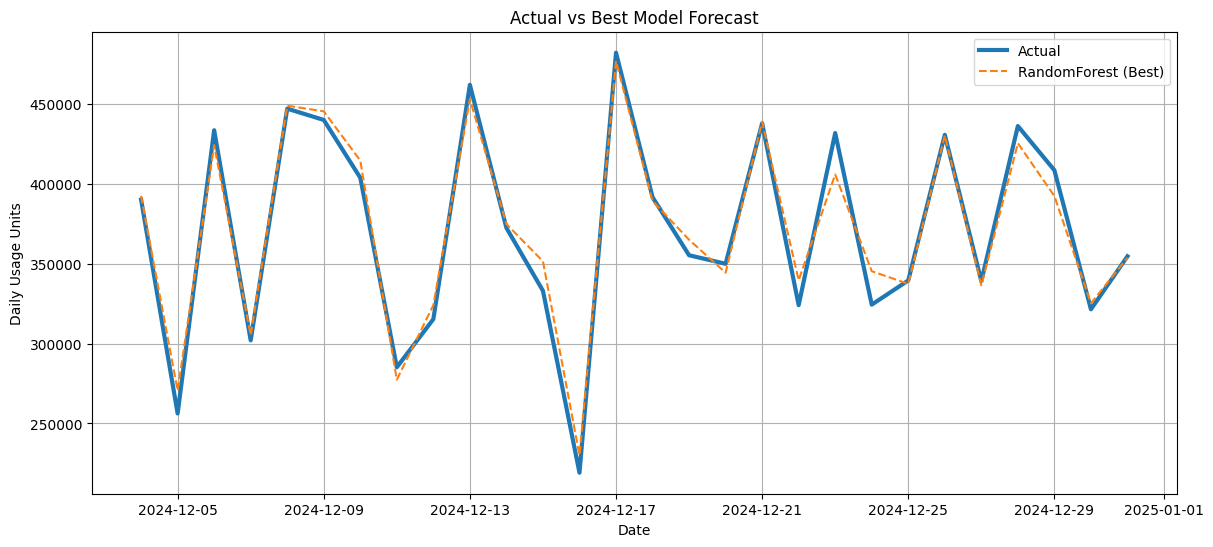

In [0]:
# --------------------------------------------
# ADD ACCURACY (%) BASED ON SMAPE
# --------------------------------------------
results_df["Accuracy (%)"] = 100 - results_df["SMAPE"]

# Display updated results
display(results_df)

# --------------------------------------------
# IDENTIFY BEST MODEL
# --------------------------------------------
best_model = results_df.loc[results_df["Accuracy (%)"].idxmax()]
print(f"Best Model: {best_model['model']}")
print(f"Best Model Accuracy: {best_model['Accuracy (%)']:.3f}%")

# --------------------------------------------
# BAR CHART - ACCURACY COMPARISON
# --------------------------------------------
plt.figure(figsize=(10, 5))
plt.bar(results_df["model"], results_df["Accuracy (%)"])
plt.title("Model Accuracy Comparison (%)")
plt.ylabel("Accuracy (%)")
plt.xlabel("Models")
plt.grid(axis='y')
plt.show()

# --------------------------------------------
# BAR CHART - SMAPE COMPARISON
# --------------------------------------------
plt.figure(figsize=(10, 5))
plt.bar(results_df["model"], results_df["SMAPE"])
plt.title("Model SMAPE Comparison (Lower is Better)")
plt.ylabel("SMAPE")
plt.xlabel("Models")
plt.grid(axis='y')
plt.show()

# --------------------------------------------
# LINE PLOT - ACTUAL VS BEST MODEL PREDICTIONS
# --------------------------------------------
plt.figure(figsize=(14, 6))

plt.plot(test.index, y_true, label='Actual', linewidth=3)

if best_model['model'] == 'RandomForest':
    plt.plot(test.index, rf_preds, label='RandomForest (Best)', linestyle='--')
elif best_model['model'] == 'XGBoost':
    plt.plot(test.index, xgb_preds, label='XGBoost (Best)', linestyle='--')
elif best_model['model'] == 'ARIMA':
    plt.plot(test.index, arima_forecast, label='ARIMA (Best)', linestyle='--')
else:
    plt.plot(test.index, prophet_forecast, label='Prophet (Best)', linestyle='--')

plt.title("Actual vs Best Model Forecast")
plt.xlabel("Date")
plt.ylabel("Daily Usage Units")
plt.legend()
plt.grid(True)
plt.show()


In [0]:
# Convert Pandas → Spark
results_df.columns = [col.replace(' ', '_').replace(';', '_').replace(',', '_').replace('{', '_').replace('}', '_').replace('(', '_').replace(')', '_').replace('\n', '_').replace('\t', '_').replace('=', '_') for col in results_df.columns]; results_spark = spark.createDataFrame(results_df)

# Save as a managed table inside hive_metastore
results_spark.write.mode("overwrite").format("delta").saveAsTable("hive_metastore.default.forecasting_model_summary")

In [0]:
%sql
SELECT * FROM hive_metastore.default.forecasting_model_summary;


model,MAE,RMSE,SMAPE,Accuracy__%_
XGBoost,9068.53627232143,11743.222226523614,2.539107826383422,97.46089217361657
RandomForest,8137.451884278852,10452.599281892997,2.3137917976357922,97.68620820236421
ARIMA,57345.69340109584,70131.4034114704,15.80210548762086,84.19789451237914
Prophet,57345.775211006294,70423.29892361627,15.808513780547973,84.19148621945203


In [0]:
# Convert Pandas → Spark
results_spark = spark.createDataFrame(results_df)

# Save as Delta table inside hive_metastore.default
results_spark.write.mode("overwrite").format("delta").saveAsTable(
    "hive_metastore.default.forecasting_model_summary"
)

In [0]:
%sql
SHOW TABLES IN hive_metastore.default;


database,tableName,isTemporary
default,forecasting_model_summary,false
default,gold_clean,false
default,gold_features,false
default,prophet_accuracy,false
default,prophet_forecast,false
default,silver_merged_table,false
